[Black Friday Sales Prediction:](https://datahack.analyticsvidhya.com/contest/black-friday/#ProblemStatement) Build a model to predict Black Friday sales.

# Setup

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "black_friday_sales_prediction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the data

## Download the data

In [115]:
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets", PROJECT_ID)

def create_dir(file_path):
    if not os.path.isdir(file_path):
        os.makedirs(file_path)

In [116]:
create_dir(DATASETS_PATH)

* Download `test.csv`, `train.csv`, and `sample.csv` to datasets folder

In [4]:
def load_data(path, file_name):
    csv_path = os.path.join(path, file_name)
    return pd.read_csv(csv_path)

## Take a quick look at the data structure

In [5]:
train = load_data(DATASETS_PATH, 'train.csv')

In [6]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [7]:
train_copy = train.copy()

In [8]:
import sweetviz as sv
eda = sv.analyze(train_copy)
eda.show_html('edal.html')

                                             |          | [  0%]   00:00 -> (? left)

Report edal.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Observations:
* A ton of data (550k records)
* `User_ID` could have useful info if same customer in test set. However, it should be treated as a categorical variable but there are 6k unique values. Plan to remove.
* `Product_ID` 4k unique values. Every value starts with 'P' so don't see how you can split to get useful information. Plan to remove.
* `Gender` boolean good
* `Age` binned good
* `Ocupation` binned, 21 categories, could be issue for OHE, numerical needs to be categorical
* `City_Category` binned good
* `Stay_In_Current_City_Years` binned good
* `Marital_Status` binned good, numerical needs to be categorical
* `Product_Category_1` primary category, 20 distinct, binned, needs to be categorical
* `Product_Category_2` secondary category, 17 distinct, binned, needs to be categorical, imputate missing with constant 'missing'
* `Product_Category_3` tertiary category, 15 distinct, binned, needs to be categorical, imputate missing with constant 'missing'
* `Purchase` target
* Every feature should be categorical

In [9]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [10]:
train_copy.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


Saving figure attribute_histgram_plots


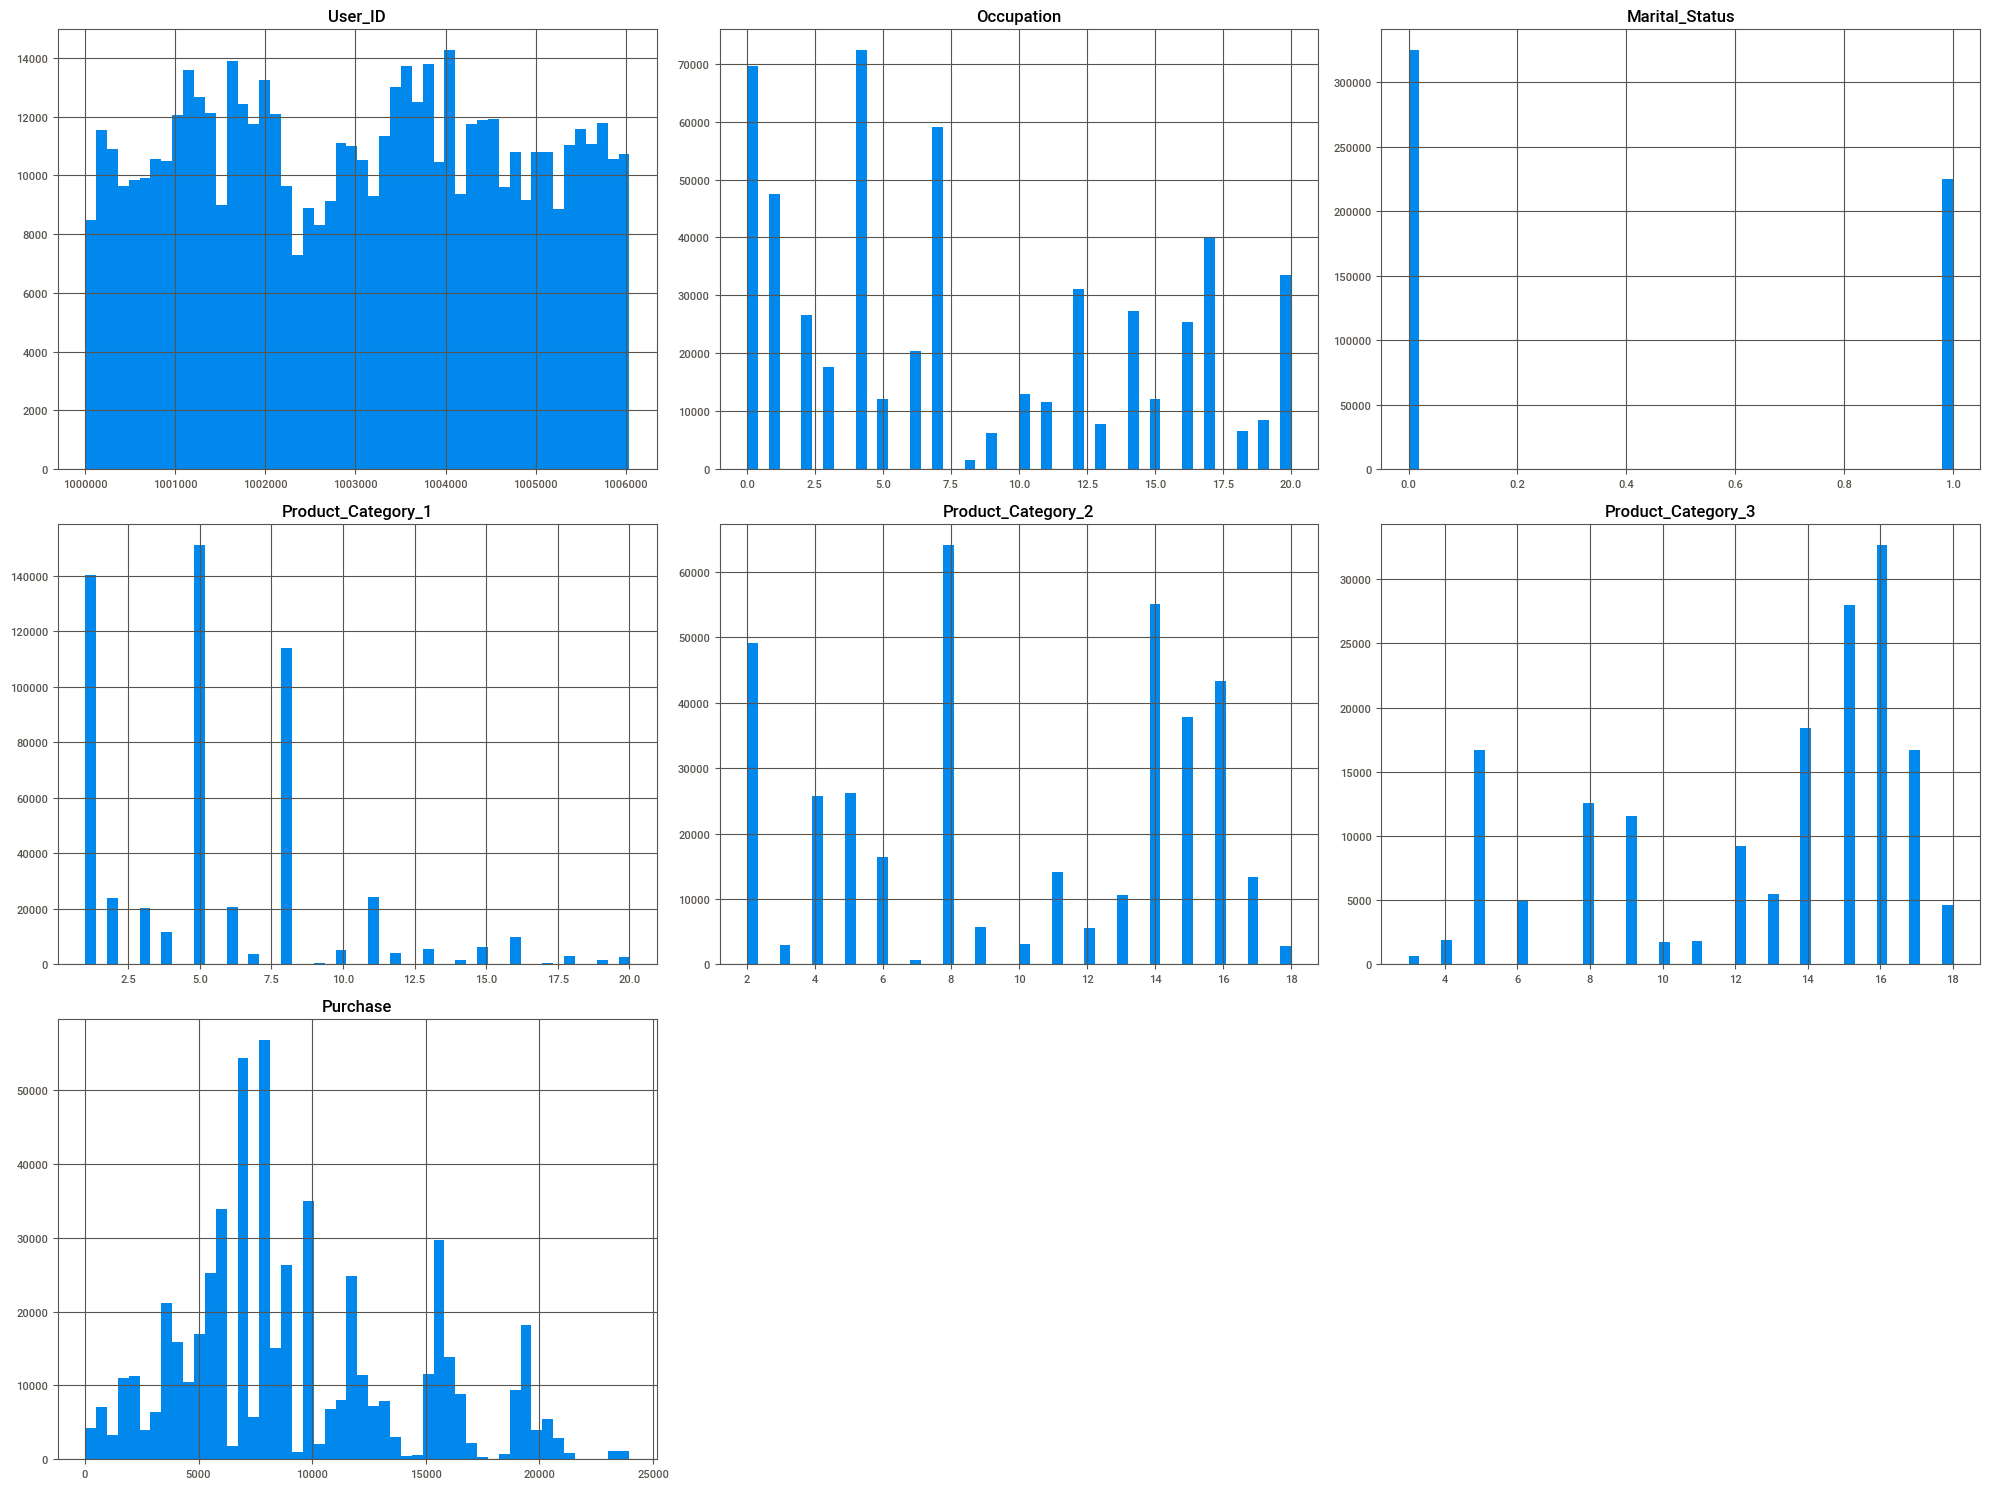

In [11]:
train_copy.hist(bins=50, figsize=(20,15))
save_fig("attribute_histgram_plots")

# Create a test set

* Test set has already been created, so not applicable here
* Plan to use k-folds cv

# EDA

## Looking for correlations

In [12]:
train_copy = train_copy.drop(['User_ID'], axis=1)

In [13]:
corr_matrix = train_copy.corr()

In [14]:
corr_matrix["Purchase"].sort_values(ascending=False)

Purchase              1.000000
Occupation            0.020833
Marital_Status       -0.000463
Product_Category_3   -0.022006
Product_Category_2   -0.209918
Product_Category_1   -0.343703
Name: Purchase, dtype: float64

* All of these are categorical, so no useful information here

## Experimenting with attribute combinations

* All categorical so nothing I can really do here

# Prepare the data for machine learning algorithms 

In [15]:
X_train = train.drop("Purchase", axis=1)  # drop labels for training set
X_labels = train["Purchase"].copy()

## Custom transformers

In [16]:
X_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3'],
      dtype='object')

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 46.2+ MB


In [18]:
for col in X_train.columns:
    print(X_train[col].dtype in ['int64', 'float64'])

True
False
False
False
True
False
False
True
True
True
True


In [19]:
def convert_num_to_cat(X: pd.DataFrame, y=None):
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            X[col] = X[col].apply(str)
    return X

## Transformation pipelines

In [20]:
from sklearn.preprocessing import FunctionTransformer

num_to_cat_estimator = FunctionTransformer(convert_num_to_cat)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('num_to_cat', num_to_cat_estimator),
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot', OneHotEncoder()),
])

In [22]:
X_train = X_train.drop(['User_ID', 'Product_ID'], axis=1)

* n.b. above step should be in pipeline, otherwise I have to drop from test set later

In [23]:
X_train_prepared = cat_pipeline.fit_transform(X_train)

In [24]:
X_train_prepared

<550068x94 sparse matrix of type '<class 'numpy.float64'>'
	with 4950612 stored elements in Compressed Sparse Row format>

In [25]:
X_train_prepared.shape

(550068, 94)

# Select and train a model 

## Fit models

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, X_labels)

LinearRegression()

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_prepared, X_labels)

RandomForestRegressor(random_state=42)

In [36]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train_prepared, X_labels)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

* Below cell was left to run overnight and still didn't complete
* Unsure what it is about this algorithm, specifically, that makes it so slow
* Plan to use Google Colab next time for GPU/TPU access

In [37]:
# from sklearn.svm import SVR

# svm_reg = SVR(kernel="linear")
# svm_reg.fit(X_train_prepared, X_labels)

## Cross-validation

In [28]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, X_train_prepared, X_labels,
                         scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

In [29]:
forest_scores = cross_val_score(forest_reg, X_train_prepared, X_labels,
                         scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

In [38]:
xgb_scores = cross_val_score(xgb_reg, X_train_prepared, X_labels,
                         scoring="neg_mean_squared_error", cv=5)
xgb_rmse_scores = np.sqrt(-xgb_scores)

In [39]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [40]:
display_scores(lin_rmse_scores)

Scores: [2992.51484568 2985.01008314 2988.042867   2990.41900923 3531.90660903]
Mean: 3097.5786828165265
Standard deviation: 217.1783311403377


In [41]:
display_scores(forest_rmse_scores)

Scores: [3045.97673911 3038.62855993 3034.62621343 3043.59413929 3031.84791307]
Mean: 3038.934712964076
Standard deviation: 5.294903523760843


In [42]:
display_scores(xgb_rmse_scores)

Scores: [2886.35589023 2886.26118067 2888.04189056 2895.18057081 3334.92117128]
Mean: 2978.1521407099162
Standard deviation: 178.41456213151406


* XGB has the lowest error
* RF has really low SD, not sure why
* Choose XGB

# Fine-tune your model

## Randomized search

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from random import random

param_distribs = {
        'max_depth': randint(low=3, high=20),
        'n_estimators': randint(low=100, high=1000),
        'learning_rate': [0.01, 0.1, 0.2, 0.3],  # not int so can't use randint
        'colsample_bytree': np.arange(0.4, 1.0, 0.1),
        'subsample': np.arange(0.5, 1.0, 0.1),
    }

xgb_reg = XGBRegressor(random_state=42)
rnd_search = RandomizedSearchCV(xgb_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train_prepared, X_labels)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
        

In [64]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

3280.1889269529433 {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 17, 'n_estimators': 206, 'subsample': 0.8999999999999999}
3217.978905039001 {'colsample_bytree': 0.7999999999999999, 'learning_rate': 0.2, 'max_depth': 13, 'n_estimators': 558, 'subsample': 0.8999999999999999}
2968.6431502223413 {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 761, 'subsample': 0.8999999999999999}
3204.564931737294 {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 14, 'n_estimators': 513, 'subsample': 0.6}
3214.061168833846 {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 559, 'subsample': 0.6}
2955.1408048078406 {'colsample_bytree': 0.8999999999999999, 'learning_rate': 0.01, 'max_depth': 14, 'n_estimators': 956, 'subsample': 0.5}
3093.725311381496 {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 575, 'subsample': 0.7999999999999999}
3243.9187012106086 {'colsample_bytree': 0.8999999999

* Best performance with high `colsample_bytree`: .90, low `learning_rate`: .01, middle `max_depth`: 14, middle `n_estimators`: 559, and middle `subsample`: .6
* Not much opportunity to furthe roptimize because `colsample_bytree` at max end of range and already a low `learning_rate`
* Can expect RMSE of 2955 on test set

## Analyze the best models and their errors

In [85]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.00040189, 0.00040724, 0.00052791, 0.00047656, 0.00043729,
       0.00048485, 0.00046942, 0.00050746, 0.00052412, 0.00054156,
       0.00055265, 0.00066792, 0.0005733 , 0.00052646, 0.00049068,
       0.00059811, 0.00057333, 0.00055608, 0.00055048, 0.00058364,
       0.00064691, 0.00059755, 0.00060731, 0.00057599, 0.00063154,
       0.00060838, 0.00059964, 0.00056556, 0.00055106, 0.00056655,
       0.00045115, 0.0004337 , 0.00086612, 0.00046797, 0.000469  ,
       0.00049503, 0.00052975, 0.00050661, 0.00046491, 0.00048562,
       0.07428177, 0.09967589, 0.02641867, 0.04273362, 0.0425796 ,
       0.02186844, 0.04434049, 0.09016795, 0.01963813, 0.0557156 ,
       0.05906865, 0.01601104, 0.07139137, 0.02141861, 0.02330493,
       0.01839611, 0.10472254, 0.07121001, 0.02129501, 0.01341508,
       0.00192512, 0.00070621, 0.00040182, 0.00067947, 0.00050935,
       0.00082922, 0.00075103, 0.00173573, 0.00118035, 0.00063621,
       0.00052835, 0.00607975, 0.00157815, 0.00080898, 0.00051

In [94]:
cat_encoder = cat_pipeline[2]
cat_one_hot_attribs = list(cat_encoder.get_feature_names())
sorted(zip(feature_importances, cat_one_hot_attribs), reverse=True)

[(0.10472254, 'x6_6'),
 (0.099675894, 'x6_10'),
 (0.090167955, 'x6_16'),
 (0.074281774, 'x6_1'),
 (0.07139137, 'x6_20'),
 (0.07121001, 'x6_7'),
 (0.05906865, 'x6_19'),
 (0.055715602, 'x6_18'),
 (0.044340488, 'x6_15'),
 (0.04273362, 'x6_12'),
 (0.042579602, 'x6_13'),
 (0.026418665, 'x6_11'),
 (0.023304926, 'x6_4'),
 (0.021868441, 'x6_14'),
 (0.021418612, 'x6_3'),
 (0.02129501, 'x6_8'),
 (0.01963813, 'x6_17'),
 (0.018396107, 'x6_5'),
 (0.016011035, 'x6_2'),
 (0.013415084, 'x6_9'),
 (0.006079753, 'x7_4.0'),
 (0.0032979508, 'x7_8.0'),
 (0.003025874, 'x8_4.0'),
 (0.0022542707, 'x8_8.0'),
 (0.001925116, 'x7_10.0'),
 (0.0017357277, 'x7_17.0'),
 (0.0015781486, 'x7_5.0'),
 (0.0015135347, 'x8_18.0'),
 (0.0014372242, 'x8_17.0'),
 (0.0013558147, 'x7_nan'),
 (0.0011803486, 'x7_18.0'),
 (0.001072433, 'x8_9.0'),
 (0.00088572607, 'x8_nan'),
 (0.0008661175, 'x3_C'),
 (0.0008552752, 'x8_6.0'),
 (0.0008292221, 'x7_15.0'),
 (0.0008089797, 'x7_6.0'),
 (0.0007510271, 'x7_16.0'),
 (0.0007256893, 'x8_11.0'),


* n.b. don't seem to be doing this right because I don't recognize any of these feature names

# Evaluate system on test set

## Generate predictions

In [111]:
final_model = rnd_search.best_estimator_

X_test = load_data(DATASETS_PATH, 'test.csv')
X_test_copy = X_test.drop(['User_ID', 'Product_ID'], axis=1)
X_test_prepared = cat_pipeline.transform(X_test_copy)
final_predictions = final_model.predict(X_test_prepared)

 ## Create prediction file

In [113]:
user_id = X_test['User_ID']
product_id = X_test['Product_ID']

submission_df_1 = pd.DataFrame({
    "Purchase": final_predictions,
    "User_ID": user_id,
    "Product_ID": product_id
})

In [117]:
SUBMISSIONS_PATH = os.path.join('submissions', 'black_friday_sales_prediction')
create_dir(SUBMISSIONS_PATH)

In [118]:
def save_submission(model, path, file_name, index=False):
    csv_path = os.path.join(path, file_name)
    return model.to_csv(csv_path, index=index)

In [119]:
save_submission(submission_df_1, SUBMISSIONS_PATH, 'submission_1.csv')

## Save model

In [123]:
MODELS_PATH = os.path.join('models', 'black_friday_sales_prediction')
create_dir(MODELS_PATH)

In [124]:
def save_model(path, model_name, model):
    model_path = os.path.join(path, model_name)
    joblib.dump(model, model_path)

In [125]:
import joblib

save_model(MODELS_PATH, 'final_model.pkl', final_model)